# Analysis of InDel-assembled mixed linker microcin library
Withanage et al.
> 07/23 - V. Pinheiro - v.1.0

In [3]:
# Relevant libraries required for the analysis
using DelimitedFiles
using Plots
using BioSequences
using DataStructures
using Combinatorics
using DataFrames
using CSV
using BenchmarkTools
using FASTX
using StatsBase
using Distributions
using TypedTables

## Creating a summary of the library design

In [4]:
## functions needed for this section

function rev_comp(str)
    # simple function to generate reverse complement of each string
    # since BsaI assembly is done in the antisense strand
    str2=""
    for i = length(str):-1:1
        if str[i] == 'A'
            str2 = str2 * "T"
        elseif str[i] == 'C'
            str2 = str2 * "G"
        elseif str[i] == 'G'
            str2 = str2 * "C"
        elseif str[i] == 'T'
            str2 = str2 * "A"
        end
    end
    return str2
end
 

rev_comp (generic function with 1 method)

In [5]:
## Opening the assembly design
# Column 1: DNA sequences of the building blocks (BsaI-based)
# Column 2: Description of the part
# Subsequent columns: assembly cycles with molar ratios of building blocks used at each cycle

design = DataFrame(CSV.File("Indel_Mixed_library.csv"));
sort!(design, :Block)

## Removing missing values from design file
design = coalesce.(design, 0);

In [6]:
## Adding an ID and block length
ID_addon = DataFrame([[],[],[]], ["ID", "Block", "Block_length"])
for n = 1: size(design, 1)
    ID = n
    new_block = design.Block[n]
    new_block_length = length(design.Block[n])

    entry = DataFrame(permutedims([ID, new_block, new_block_length]), ["ID", "Block", "Block_length"])
    append!(ID_addon, entry)
end

design = innerjoin(design, ID_addon, on = :Block)

#= Because it is possible for small blocks to be confused with larger 
    ones, interpretation has to be carried out "backwards", trying to identify longer
    blocks before shorter ones. =#
sort!(design, :Block_length, rev=true);

In [7]:
## Defining the sequences that are added in assembly, i.e. the true building blocks
core_blocks = DataFrame([[],[], []], ["ID", "Block_core", "Block_core_RC"])

for n = 1: size(design, 1)
    ID = design.ID[n]
    new_core = design.Block[n][findall("GGTCTC", design.Block[n])[1][end]+2:end]
    new_rccore = rev_comp(new_core)

    entry = DataFrame(permutedims([ID, new_core, new_rccore]), ["ID", "Block_core", "Block_core_RC"])
    append!(core_blocks, entry)
end

design = innerjoin(core_blocks, design  , on = :ID)

Row,ID,Block_core,Block_core_RC,Block,Description,Cycle_1,Cycle_2,Cycle_3,Cycle_4,Cycle_5,Cycle_6,Block_length
,Any,Any,Any,String,String31,Int64,Int64,Int64,Int64,Int64,Int64,Any
1,12,CTCCCATTTTATGGCGGCGAG,CTCGCCGCCATAAAATGGGAG,GACATACAGACAGGGATGAGGTCTCTCTCCCATTTTATGGCGGCGAG,(B17_lib)_CC_motif_B,0,1,1,1,1,0,47
2,8,ATTATTCTGCTGGTTGTT,AACAACCAGCAGAATAAT,GACATACAGACAGGGATGAGGTCTCTATTATTCTGCTGGTTGTT,(B17_lib)_Prion_B,0,1,1,1,1,0,44
3,13,CTTTGCTGCTGCCTC,GAGGCAGCAGCAAAG,GACATACAGACAGGGATGAGGTCTCTCTTTGCTGCTGCCTC,(B17_lib)_EAAAK_B,0,1,1,1,1,0,41
4,1,ACAACAACC,GGTTGTTGT,GACATACAGACAGGGATGAGGTCTCTACAACAACC,(B17_lib)_GCC_B,1,0,0,0,0,1,35
5,3,ACACGAGCC,GGCTCGTGT,GACATACAGACAGGGATGAGGTCTCTACACGAGCC,(B17_lib)_GSC_B,1,0,0,0,0,1,35
6,4,ACCACCACC,GGTGGTGGT,GACATACAGACAGGGATGAGGTCTCTACCACCACC,(B17_lib)_GGG_B,0,1,1,1,1,0,35
7,5,AGAACATCC,GGATGTTCT,GACATACAGACAGGGATGAGGTCTCTAGAACATCC,(B17_lib)_GCS_B,1,0,0,0,0,1,35
8,6,AGAAGAACC,GGTTCTTCT,GACATACAGACAGGGATGAGGTCTCTAGAAGAACC,(B17_lib)_GSS_B,1,0,0,0,0,1,35
9,9,CCTCCTCCT,AGGAGGAGG,GACATACAGACAGGGATGAGGTCTCTCCTCCTCCT,(B17_lib)_polyR3_B,0,1,1,1,1,0,35


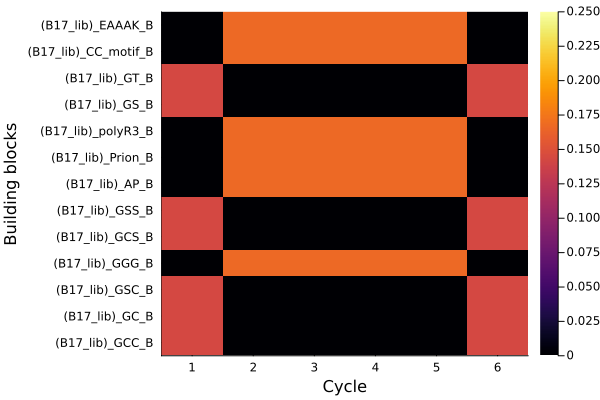

In [8]:
design_for_plotting = sort(design, :ID)

## Creating a display of the assembly program
total_cycles = 0
assembly_matrix = []
for i = 1:size(design_for_plotting, 2)
    if occursin("Cycle", names(design_for_plotting)[i]) && total_cycles == 0
        assembly_matrix = design_for_plotting[:, i]./sum(design_for_plotting[:, i])
        total_cycles += 1
    elseif occursin("Cycle", names(design_for_plotting)[i]) && total_cycles > 0  
        new_cycle = design_for_plotting[:, i]./sum(design_for_plotting[:, i])
        assembly_matrix = hcat(assembly_matrix, new_cycle)
        total_cycles += 1
    end
end

heatmap([string(n) for n = 1:total_cycles], 
[string(block) for block in design_for_plotting.Description],
assembly_matrix, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.25))

#= This is the recipe for assembly. Using this recipe, it is possible to simulate assembly and determine the 
expected distribution for all intermediate lengths. This is not carried out here. =#

## Importing and filtering NGS data

In [9]:
## Functions relevant for analysis

# Load FASTA file as an Array of String
function load_fasta_file(file_name::String)
    R0 = []
    reader = FASTA.Reader(open(file_name, "r"))
    for record in reader
        push!(R0, convert(String, FASTA.sequence(record)))
    end
    close(reader)
    return R0
end


# Opens a FASTA file and isolates the sequences flanked by both upstream and downstream elements
function isolate_insert(File::String, upstream::String, downstream::String)
    full_seq = []
    all_seq = load_fasta_file(File)

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end] # finds the end of the upstream
            edge2 = findfirst(downstream, all_seq[n])[1] # finds the beginning of downstream
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq

end  

isolate_insert (generic function with 1 method)

In [16]:
upstream = "AACCTCTATTTCCAG" # TEV site immediately upstream of cloning site
downstream = "TCACATATCTGAAGG" # GSHI conserved peptide sequence

## Opens the Galaxy pre-trimmed sequences in FASTA format and isolates the microcin sequences
full_seq = isolate_insert("Mixed_library_galaxy_pear.fasta", upstream, downstream)

## Goes through the DNA sequences to identify repeats, through a dictionary
NGS_processing = Dict{String, Int64}()
NGS_data = DataFrame([[], [], [], []], ["Sequence_number", "Microcin_sequence", "Microcin_assembly", "Count"])
for i = 1: size(full_seq, 1)
    if haskey(NGS_processing, full_seq[i])
        NGS_processing[full_seq[i]] += 1
    else
        NGS_processing[full_seq[i]] = 1
    end
end

# Remaps the dictionary to a DataFrame for subsequent analysis
for (key, value) ∈ NGS_processing   # converts dictionary to DataFrame
    entry = DataFrame([[0], [key], [[]], [value]], ["Sequence_number", "Microcin_sequence", "Microcin_assembly", "Count"])
    append!(NGS_data, entry)
end
sort!(NGS_data, :Count, rev=true)

# Introduces a sequence number for convenience in later analysis
for n = 1:size(NGS_data, 1)
    NGS_data.Sequence_number[n] = n
end

In [11]:
# Saves the dataframe as a CSV for convenience
CSV.write("NGS_full_data_pear.csv", NGS_data)

# Summary: (total number of reads, number of different sequences)
(sum(NGS_data.Count), size(NGS_data, 1))

#= Errors are expected to emerge from sequencing, sample preparation artefacts, as well as PCR generation of the library.
In the absence of any error correction process, the number of different sequences obtained here is expected to
be an overestimate of the true diversity in the library =#

(7701628, 2519663)

## Identifying assembly order for individual sequences

In [18]:
## Functions relevant to the assembly program

# Generates all sequences within a defined Hamming distance 
function hamming(sequence::String, distance::Int)
    output = [] # creates a space for output
    new_entry = []
    bases = ['A', 'C', 'G', 'T']
   

    # calculating all sequences to be searched
    positions = collect(combinations(collect(UnitRange(1, length(sequence))), distance)) # generates all the positions
    variants = collect(multiset_permutations(bases, [distance,distance,distance,distance], distance)) # generates all the nucleobase variants

    for i = 1: size(positions, 1)
        for j = 1: size(variants, 1)
            new_entry = collect(sequence)
            for x = 1: distance
                new_entry[positions[i][x]] = variants[j][x]
            end
            push!(output, join(new_entry))
        end
    end

    return unique(output)
end

# Generates all sequences within a Hamming distance of 1 or with 1 deletion (i.e. not quite Levenshtein distance)
function seq_neighbours(sequence::String)
    output = [] # creates a space for output
    new_entry = []
    bases = ['A', 'C', 'G', 'T', ' ']
    
    distance = 1

    # calculating all sequences to be searched
    positions = collect(combinations(collect(UnitRange(1, length(sequence))), distance)) # generates all the positions
    variants = collect(multiset_permutations(bases, [distance,distance,distance,distance, distance], distance)) # generates all the nucleobase variants

    for i = 1: size(positions, 1)
        for j = 1: size(variants, 1)
            new_entry = collect(sequence)
            for x = 1: distance
                new_entry[positions[i][x]] = variants[j][x]
            end
            push!(output, join(new_entry))
        end
    end
    unique!(output)
    for n = 1: size(output, 1)
        if occursin(" ", output[n])
            space = findfirst(" ", output[n])[1]
            output[n] = output[n][1:space-1]*output[n][space+1:end]
        end
    end
    push!(output, sequence)    
    return output
end

        
# Reconstructs a sequence based on the design file provided
function RE_assemble(read::String, design::DataFrame)

    # starts the incorporation counter
    successful_incorporations = 0

    # first routine picks out all 100% correct matches with blocks
    analysis = Dict{Int64, Vector{UnitRange{Int64}}}()
    for x = 1: size(design, 1)
        ## generating correct sequences
        test_seqs = [design.Block_core_RC[x]]
        for y = 1: size(test_seqs, 1)
            query = Regex(test_seqs[y])
            for m in eachmatch(query, read, overlap=false)
                interval = m.offset:(m.offset+length(test_seqs[y])-1)
                if haskey(analysis, design.ID[x])
                    analysis[design.ID[x]] = vcat(analysis[design.ID[x]],  [interval])
                    successful_incorporations += 1
                else
                    analysis[design.ID[x]] = [interval]
                    successful_incorporations += 1
                end
            end
        end
    end

    # second routine picks out error-containing matches (up to 1 error)
    analysis_werrors = Dict{Int64, Vector{UnitRange{Int64}}}()
    for x = 1: size(design, 1)
        ## generating all testable sequences
        test_seqs = seq_neighbours(design.Block_core_RC[x])
        for y = 1: size(test_seqs, 1)
            query = Regex(test_seqs[y])
            for m in eachmatch(query, read, overlap=false)
                interval = m.offset:(m.offset+length(test_seqs[y])-1)
                if haskey(analysis_werrors, design.ID[x])
                    analysis_werrors[design.ID[x]] = vcat(analysis_werrors[design.ID[x]],  [interval])
                else
                    analysis_werrors[design.ID[x]] = [interval]
                end
            end
        end
    end

    # sanity checks if troubleshooting is required
    # sort(collect(analysis), by = x->x[2])
    # sort(collect(analysis_werrors), by = x->x[1])


    # tries to locate all error-free assemblies
    total_coverage = []
    for i = 1: size(collect(analysis), 1)
        for j = 1: size(collect(analysis)[i][2], 1)
            total_coverage = total_coverage ∪ collect(analysis)[i][2][j]
        end
    end
    sequence_to_map = 1:length(read)
    # determines the positions in the sequence not mapped
    not_found = setdiff(sequence_to_map,total_coverage)


    # starts mapping with sequences containing 1 error to the still available space
    for attempts = 1: (total_cycles - successful_incorporations + 1) # one cycle beyond the library synthesis plan is used here for error catching
        Error_correction = DataFrame([[], [], []], ["ID", "sequence_overlap", "Remaining_bases"])

        for i = 1: size(collect(analysis_werrors), 1)
            for j = 1: size(collect(analysis_werrors)[i][2], 1)
                test_range = collect(analysis_werrors)[i][2][j]
                if test_range ∩ not_found == test_range
                    seq_ID = collect(analysis_werrors)[i][1]
                    remaining = length(not_found) - length(test_range)
                    new_entry = DataFrame([[seq_ID], [test_range], [remaining]], ["ID", "sequence_overlap", "Remaining_bases"])
                    append!(Error_correction, new_entry)
                end
            end
        end

        sort!(Error_correction, :Remaining_bases)
        if isempty(Error_correction) == false
            # adds new sequences to the same dictionary containing the error-free identifications
            if haskey(analysis, Error_correction.ID[1])
                analysis[Error_correction.ID[1]] = vcat(analysis[Error_correction.ID[1]], [Error_correction.sequence_overlap[1]])
            else
                analysis[Error_correction.ID[1]] = [Error_correction.sequence_overlap[1]]  
            end
            successful_incorporations += 1
    
        not_found = setdiff(not_found, Error_correction.sequence_overlap[1] )
        end
    end    

    # This routine uses the "analysis" dictionary to reconstruct the assembly order
    re_assembly = DataFrame([[], []], ["ID", "sequence_overlap"])
    if length(not_found) <= 10
        for i = 1: size(collect(analysis), 1)
            for j = 1: size(collect(analysis)[i][2], 1)
                ID = collect(analysis)[i][1][]
                range = collect(analysis)[i][2][j]

                new_entry = DataFrame([[ID], [range]], ["ID", "sequence_overlap"])
                re_assembly = append!(re_assembly, new_entry)
            end
        end
        sort!(re_assembly, :sequence_overlap)
        re_assembly_order = re_assembly.ID
    else
        # ensures that sequences that cannot be correctly assembled are removed from the list
        successful_incorporations = 0
    end

    return re_assembly.ID, successful_incorporations
end


RE_assemble (generic function with 1 method)

In [ ]:
## Given the number of sequences to be processed, it is most efficient to write directly to file.
open("reassembly_pear.csv", "w") do io
    println(io, "Sequence_number;block_numbers;block_order;Count")
    for n  = 1: size(NGS_data, 1)
        (order, number) = RE_assemble(NGS_data.Microcin_sequence[n], design)
        println(io, string(n) * ";" * string(number) * ";" * string(order) * ";" * string(NGS_data.Count[n]))
    end
end

## Analysing the reconstructed library

In [38]:
## Loading the file generated from asesmbly
dataset = DataFrame(CSV.File("reassembly_pear.csv", delim=";"))
    
# Removes any sequences that have more blocks than possible due to the assembly program
dataset = filter(row -> row.block_numbers <= total_cycles, dataset)

Row,Sequence_number,block_numbers,block_order,Count
,Int64,Int64,String31,Int64
1,1,1,Any[2],443610
2,2,2,"Any[7, 11]",70716
3,3,1,Any[6],58981
4,4,1,Any[7],52913
5,5,1,Any[8],40400
6,6,2,"Any[6, 11]",38071
7,7,1,Any[10],35316
8,8,1,Any[11],32117
9,9,2,"Any[7, 2]",31313


In [39]:
#= Sequences that cannot be assembled by the RE_assemble function are annotated as 0-block assemblies
which are expected to skew estimates of how efficient the InDel assembly was. I analyse here the distribution of 
lengths present among the 0-block assemblies to demonstrate that assembly failure does not equate to empty vectors =#

# Creates a separate dataset with sequences that cannot be assembled
zero_cycle = filter(row -> row.block_numbers == 0, dataset)
zero_cycle = innerjoin(NGS_data, select!(zero_cycle, Not([:Count])), on=:Sequence_number)

Row,Sequence_number,Microcin_sequence,Microcin_assembly,Count,block_numbers,block_order
,Any,Any,Any,Any,Int64,String31
1,55,GTGTGGTT,Any[],7393,0,Any[]
2,94,GGGGGATACTGGTT,Any[],4949,0,Any[]
3,234,GGGGGGCT,Any[],1968,0,Any[]
4,342,GGGGGATAATGGTT,Any[],1331,0,Any[]
5,381,GGGGGGAGGTGCTGGGACGGGTT,Any[],1219,0,Any[]
6,426,GGGGGACAACAGCAGAATAATGGCTCGTGTGGTT,Any[],1097,0,Any[]
7,435,GGGGGGGACGGCAGCGAAGGGGTCGGGTT,Any[],1073,0,Any[]
8,441,GGGGGGTTCTTCTAGTGGTGGTTGTTGTT,Any[],1066,0,Any[]
9,472,GGGGGGCGCGGGTGCTCCTGGTT,Any[],1014,0,Any[]


In [40]:
# Looks at the length of the sequences for which assembly failed
insert_lenghts = []
for n in zero_cycle.Microcin_sequence
    element = length(n)
    push!(insert_lenghts, element)
end

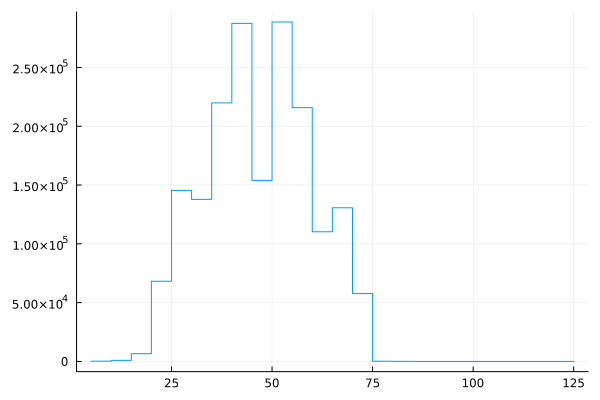

In [41]:
histogram(insert_lenghts, nbins = 40, labels=false)
# increasing the number of bins allows clear vizualization of the reading frame
# it is clear that while the assembly algorithm is working, there are many exceptions that differ
# by more than 1 base from the expected sequencing blocks

In [42]:
## Estimate of assembly efficiency
viableAssembly = sum(dataset.Count) - sum(zero_cycle.Count)
assemblyEfficiency = viableAssembly / sum(dataset.Count)

#= Introduction of additional or more advanced error-catching mechanisms could further improve
the assembly efficiency, if needed. One such approach is to focus analysis on non-unique sequences.
Unique sequences are the most likely to contain errors but also the rarer assembled sequences (as it
would be expected for 6-block assemblies) =#

0.7178776580972449

### Analysis excluding unique sequences


In [43]:
nonUnique = filter(row -> row.Count > 1, dataset)
sum(nonUnique.Count)

5421405

In [44]:
# Creates a separate dataset with sequences that cannot be assembled
zero_cycle_nonUnique = filter(row -> row.block_numbers == 0, nonUnique)
zero_cycle_nonUnique = innerjoin(NGS_data, select!(zero_cycle_nonUnique, Not([:Count])), on=:Sequence_number);

In [45]:
# Looks at the length of the sequences for which assembly failed
insert_lenghts_nonUnique = []
for n in zero_cycle_nonUnique.Microcin_sequence
    element = length(n)
    push!(insert_lenghts_nonUnique, element)
end

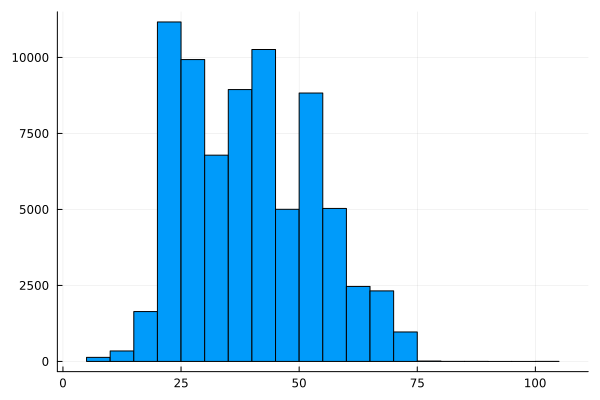

In [46]:
histogram(insert_lenghts_nonUnique, nbins = 40, labels=false)
# increasing the number of bins allows clear vizualization of the reading frame

In [47]:
## Estimate of assembly efficiency
viableAssemblyNonUnique = sum(nonUnique.Count) - sum(zero_cycle_nonUnique.Count)
assemblyEfficiencyNonUnique = viableAssemblyNonUnique / sum(nonUnique.Count)

#= As expected, removal of unique sequences, that are expected to contain a higher sequencing error load,
improves the reconstruction efficiency =#

0.9221212951255255

In [48]:
## Generating a histogram for estimating incorporation efficiency per round - not excluding unassembled sequences
incorporation = Dict{Int64, Int64}()

for i = 1: size(nonUnique, 1)
    if haskey(incorporation, nonUnique.block_numbers[i])
        incorporation[nonUnique.block_numbers[i]] += nonUnique.Count[i]
    else
        incorporation[nonUnique.block_numbers[i]] = nonUnique.Count[i]
    end
end

sort(collect(incorporation), by= x -> x[1])

7-element Vector{Pair{Int64, Int64}}:
 0 => 422212
 1 => 1087772
 2 => 1137859
 3 => 1255448
 4 => 952524
 5 => 473674
 6 => 91916

In [50]:
## Estimating efficiency of incorporation per round
incorporation_per_round = fit_mle(Binomial, maximum(collect(incorporation))[1], 
    nonUnique.block_numbers, nonUnique.Count)

Binomial{Float64}(n=6, p=0.42608253764476184)

In [53]:
## Repeating the calculation but removing the 0-block assemblies, which are shown above as not empty constructs
nonUniqueNonZero = filter(row -> row.block_numbers > 0, nonUnique);
## Estimating efficiency of incorporation per round
incorporation_per_round = fit_mle(Binomial, maximum(collect(incorporation))[1], 
    nonUniqueNonZero.block_numbers, nonUniqueNonZero.Count)


Binomial{Float64}(n=6, p=0.4620677777393271)

### Analysis including unique sequences

In [55]:
# This removes 0-block assemblies
datasetNonZero = filter(row -> row.block_numbers > 0, dataset);

In [58]:
## Generating a histogram for estimating incorporation efficiency per round
incorporationUnique = Dict{Int64, Int64}()

for i = 1: size(datasetNonZero, 1)
    if haskey(incorporationUnique, datasetNonZero.block_numbers[i])
        incorporationUnique[datasetNonZero.block_numbers[i]] += datasetNonZero.Count[i]
    else
        incorporationUnique[datasetNonZero.block_numbers[i]] = datasetNonZero.Count[i]
    end
end

sort(collect(incorporationUnique), by= x -> x[1])

6-element Vector{Pair{Int64, Int64}}:
 1 => 1092492
 2 => 1192895
 3 => 1388113
 4 => 1123853
 5 => 603441
 6 => 125757

In [59]:
## Estimating efficiency of incorporation per round
incorporation_per_round = fit_mle(Binomial, maximum(collect(incorporationUnique))[1], 
    datasetNonZero.block_numbers, datasetNonZero.Count)

Binomial{Float64}(n=6, p=0.479798340773477)

### Assessing library coverage
For this section, all correctly assembled sequences are used (including unique)


In [62]:
## Deduplicating the library after re-assembly
#= Because the re-assembly of the library blocks includes some steps towards reconstructing blocks with errors
duplications emerge in the assembly and this routine allows that to be removed. =#

sequences = Dict{Vector{Int64}, Int64}()
for i = 1: size(datasetNonZero, 1)
    correct_block = parse.(Int,split(replace(datasetNonZero.block_order[i], r"[^0-9.]"=>" ")))
    if haskey(sequences, correct_block)
        sequences[correct_block] += datasetNonZero.Count[i]
    else
        sequences[correct_block] = datasetNonZero.Count[i]
    end
end

collated_sequences = collect(sequences)

analysis_dataset = DataFrame([[],[],[]], ["block_numbers", "block_array", "Count"])

for i = 1: size(collated_sequences, 1)
    entry = collated_sequences[i][1]
    number = length(entry)
    count = collated_sequences[i][2]

    new_entry = DataFrame([[number], [entry], [count]], ["block_numbers", "block_array", "Count"])
    append!(analysis_dataset, new_entry)
end

sort!(analysis_dataset, :Count, rev=true);

In [65]:
## Looking at positional composition - single incorporations
one_cycle = filter(row -> row.block_numbers == 1, analysis_dataset) #creates a subset

# Creates a frequency table
library1 = zeros(Int64, size(design, 1), 1)
for i = 1: size(one_cycle.block_array,1)
    library1[one_cycle.block_array[i][1]] += one_cycle.Count[i]
end
library1 = library1./sum(library1)
sort!(design, :ID)

# Summary: (total number of reads, number of different sequences)
Cycle1 = sum(one_cycle.Count), size(one_cycle, 1)

(1092492, 13)

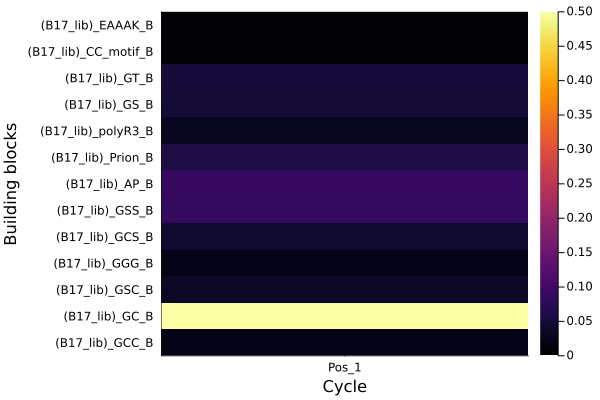

In [64]:
## Graphical representations of the coverage

# Table
summary1 = Table(Block = [string(block) for block in design.Description], Pos_1 = library1[:,1])
CSV.write("1block_assemblies.csv", summary1)

# Heatmap
heatmap(["Pos_1"], 
[string(block) for block in design.Description], library1
, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.5), show_empty=false)

In [66]:
# Looking at positional composition - 2 block incorporations
two_cycle = filter(row -> row.block_numbers == 2, analysis_dataset) #creates the subset

# Creates a frequency table
library2 = zeros(Int64, size(design, 1), 2)
for i = 1: size(two_cycle.block_array,1)
    for j = 1: size(two_cycle.block_array[i], 1)
        library2[two_cycle.block_array[i][j], j] += two_cycle.Count[i]
    end
end
library2 = library2./(sum(library2)/2)

# Gives a warning message is a block is not represented
if 0 ∈ library2
    println("Some blocks are absent")
end

# Summary: (total number of reads, number of different sequences)
Cycle2 = sum(two_cycle.Count), size(two_cycle, 1)

(1192895, 168)

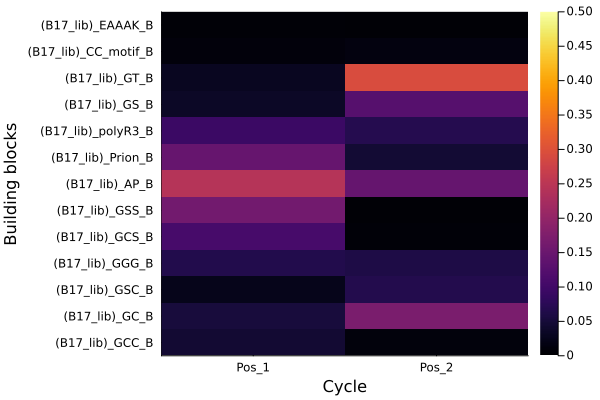

In [67]:
## Graphical representations of the coverage

# Table
summary2 = Table(Block = [string(block) for block in design.Description], Pos_1 = library2[:,1], Pos_2 = library2[:,2])
CSV.write("2block_assemblies.csv", summary2)

# Heatmap
heatmap(["Pos_1", "Pos_2"], 
[string(block) for block in design.Description], library2
, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.5), show_empty=false)

In [73]:
## Looking at positional composition - 3 blocks
three_cycle = filter(row -> row.block_numbers == 3, analysis_dataset) #creates subset

# Creates a frequency table
library3 = zeros(Int64, size(design, 1), 3)
for i = 1: size(three_cycle.block_array,1)
    for j = 1: size(three_cycle.block_array[i], 1)
        library3[three_cycle.block_array[i][j], j] += three_cycle.Count[i]
    end
end
library3 = library3./(sum(library3)/3)

# Gives a warning message is a block is not represented
if 0 ∈ library3
    println("Some blocks are absent")
end

# Summary: (total number of reads, number of different sequences)
Cycle3 = sum(three_cycle.Count), size(three_cycle, 1)

(1388113, 1469)

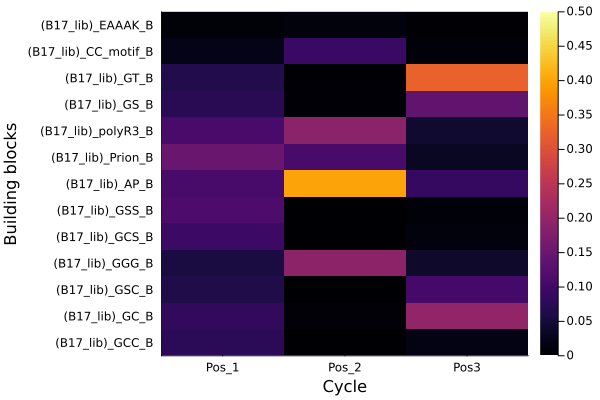

In [69]:
## Graphical representations of the coverage

# Table
summary3 = Table(Block = [string(block) for block in design.Description], 
    Pos_1 = library3[:,1], Pos_2 = library3[:,2], Pos_3 = library3[:,3])
CSV.write("3block_assemblies.csv", summary3)

# Heatmap
heatmap(["Pos_1", "Pos_2", "Pos3"], 
[string(block) for block in design.Description], library3
, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.5), show_empty=false)

In [72]:
## Looking at positional composition - 4 blocks
four_cycle = filter(row -> row.block_numbers == 4, analysis_dataset)

# Creates a frequency table
library4 = zeros(Int64, size(design, 1), 4)
for i = 1: size(four_cycle.block_array,1)
    for j = 1: size(four_cycle.block_array[i], 1)
        library4[four_cycle.block_array[i][j], j] += four_cycle.Count[i]
    end
end
library4 = library4./(sum(library4)/4)


# Gives a warning message is a block is not represented
if 0 ∈ library4
    println("Some blocks are absent")
end

# Summary: (total number of reads, number of different sequences)
Cycle4 = sum(four_cycle.Count), size(four_cycle, 1)

(1123853, 6176)

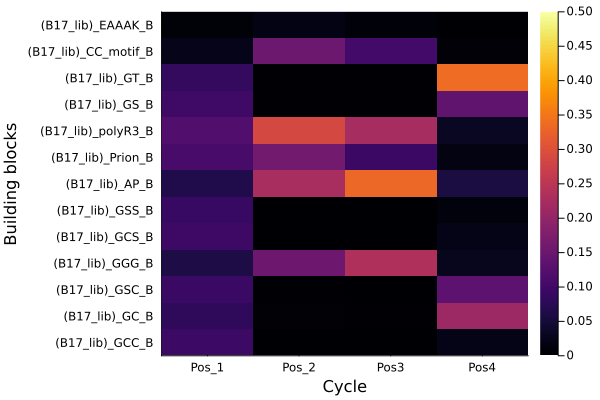

In [71]:
## Graphical representations of the coverage

# Table
summary4 = Table(Block = [string(block) for block in design.Description], 
    Pos_1 = library4[:,1], Pos_2 = library4[:,2], Pos_3 = library4[:,3], Pos_4 = library4[:,4])
CSV.write("4block_assemblies.csv", summary4)

# Heatmap
heatmap(["Pos_1", "Pos_2", "Pos3", "Pos4"], 
[string(block) for block in design.Description], library4
, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.5), show_empty=false)


In [75]:
## Looking at positional composition - 5 blocks
five_cycle = filter(row -> row.block_numbers == 5, analysis_dataset)

# Creates a frequency table
library5 = zeros(Int64, size(design, 1), 5)
for i = 1: size(five_cycle.block_array,1)
    for j = 1: size(five_cycle.block_array[i], 1)
        library5[five_cycle.block_array[i][j], j] += five_cycle.Count[i]
    end
end
library5 = library5./(sum(library5)/5)


# Gives a warning message is a block is not represented
if 0 ∈ library5
    println("Some blocks are absent")
end


# Summary: (total number of reads, number of different sequences)
Cycle5= sum(five_cycle.Count), size(five_cycle, 1)

(603441, 11546)

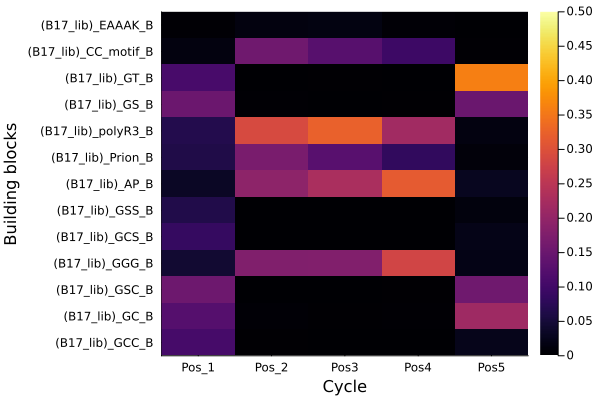

In [76]:
## Graphical representations of the coverage

# Table
summary5 = Table(Block = [string(block) for block in design.Description], 
    Pos_1 = library5[:,1], Pos_2 = library5[:,2], Pos_3 = library5[:,3],
    Pos_4 = library5[:,4], Pos_5 = library5[:,5])
CSV.write("5block_assemblies.csv", summary5)

# Heatmap
heatmap(["Pos_1", "Pos_2", "Pos3", "Pos4", "Pos5"], 
[string(block) for block in design.Description], library5
, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.5), show_empty=false)


In [77]:
## Looking at positional composition - 6 blocks
six_cycle = filter(row -> row.block_numbers == 6, analysis_dataset)

# Creates a frequency table
library6 = zeros(Int64, size(design, 1), 6)
for i = 1: size(six_cycle.block_array,1)
    for j = 1: size(six_cycle.block_array[i], 1)
        library6[six_cycle.block_array[i][j], j] += six_cycle.Count[i]
    end
end
library6 = library6./(sum(library6)/6)


# Gives a warning message is a block is not represented
if 0 ∈ library6
    println("Some blocks are absent")
end


# Summary: (total number of reads, number of different sequences)
Cycle6 = sum(six_cycle.Count), size(six_cycle, 1)

(125757, 7145)

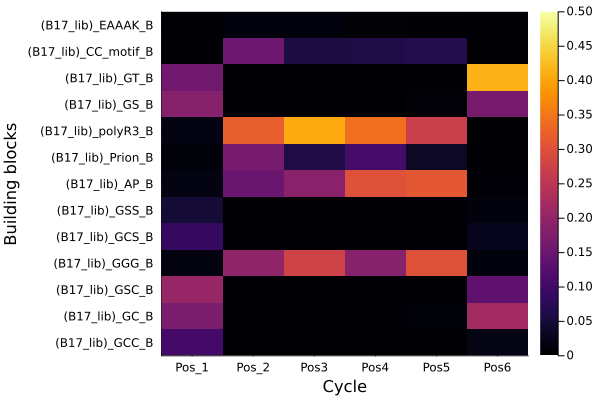

In [78]:
## Graphical representations of the coverage

# Table
summary6 = Table(Block = [string(block) for block in design.Description], 
    Pos_1 = library6[:,1], Pos_2 = library6[:,2], Pos_3 = library6[:,3],
    Pos_4 = library6[:,4], Pos_5 = library6[:,5], Pos_6 = library6[:,6])
CSV.write("6block_assemblies.csv", summary6)

# Heatmap
heatmap(["Pos_1", "Pos_2", "Pos3", "Pos4", "Pos5", "Pos6"], 
[string(block) for block in design.Description], library6
, xlabel = "Cycle" , ylabel = "Building blocks", clims=(0,0.5),show_empty=true)


In [82]:
## This creates a convenient summary of the sequence numbers and diversity
[Cycle1,Cycle2,Cycle3,Cycle4,Cycle5,Cycle6]

6-element Vector{Tuple{Int64, Int64}}:
 (1092492, 13)
 (1192895, 168)
 (1388113, 1469)
 (1123853, 6176)
 (603441, 11546)
 (125757, 7145)

In [96]:
#= Comparing the diversity per length above with what is expected, it is clear that some sequence spaces are being sampled
beyond the expected space. For instance, 3-block assemblies which are expected to have only 1014 variants unless alternative
assemblies are included, e.g. AAA, BAA. =#

Aset = [1, 2, 3, 5, 6, 10, 11]
variants = collect(with_replacement_combinations(Aset, 3))

AAA = filter(row -> row.block_array ∈ variants, three_cycle)

Row,block_numbers,block_array,Count
,Any,Any,Any
1,3,"[2, 2, 2]",1144
2,3,"[2, 2, 11]",359
3,3,"[2, 10, 11]",355
4,3,"[1, 5, 11]",262
5,3,"[2, 2, 10]",179
6,3,"[11, 11, 11]",149
7,3,"[2, 6, 11]",144
8,3,"[2, 11, 11]",142
9,3,"[2, 10, 10]",126


### Microcins characterised in this work

In [83]:
# MH10 peptide presence in original library
mh10 = filter(row -> row.block_array == [10, 12, 12, 9,11], five_cycle)

Row,block_numbers,block_array,Count
,Any,Any,Any
1,5,"[10, 12, 12, 9, 11]",251


In [84]:
mf1 = filter(row -> row.block_array == [3, 9, 7, 12, 11], five_cycle)

Row,block_numbers,block_array,Count
,Any,Any,Any
1,5,"[3, 9, 7, 12, 11]",411


In [98]:
viableAssembly

5526551